In [37]:
# import mne
# import sys
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
from mne_bids import BIDSPath, read_raw_bids
from bids import BIDSLayout
# from mne_connectivity import seed_target_indices, spectral_connectivity_time, spectral_connectivity_epochs
from util.io.coherence import *
from util.io.iter_BIDSPaths import *
from util.io.preprocessing import *

In [15]:
SUB = 9
TASK = 'pitch'
RUN = 1
BIDS_ROOT = '../data/bids'
FIGS_ROOT = '../figs'
DERIV_ROOT = '../data/bids/derivatives'
FS = 5000
RAW_TMIN = -0.2
RAW_TMAX = 0.5
TMIN = 0
TMAX = 0.25
N_CHANS = 62
CONDS = ['50', '100', '150', '200', '250']

# Subjects from which to generate stim signal
STIM_SUB = 10
STIM_RUN = 1

In [3]:
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
fpaths = layout.get(scope = 'preprocessing',
                    res = 'hi',
                    suffix='epo',
                    extension = 'fif.gz',
                    return_type = 'filename')

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


In [13]:
epochs = mne.read_epochs(fpaths[11], preload = True)
events = epochs.events
n_epochs = len(events)

Reading /project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocessing/sub-10/sub-10_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -200.00 ...     250.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
3841 matching events found
No baseline correction applied
0 projection items activated


### Simulate channels with stim signals

In [17]:
# Create epochs from raw data to create simulated stim channels
raw_epochs = get_raw_epochs(BIDS_ROOT, STIM_SUB, TASK, STIM_RUN, events)
stim_epochs_array = create_stim_epochs_array(raw_epochs, n_epochs, CONDS)
simulated_epochs = create_stim_epochs_object(stim_epochs_array, events, CONDS, FS, RAW_TMIN)

# Crop data so both epochs have same windowing
simulated_epochs = simulated_epochs.crop(tmin = TMIN, tmax = TMAX)
epochs = epochs.crop(tmin = TMIN)

# Add simulated channels to data
combined_epochs = mne.epochs.add_channels_epochs([epochs, simulated_epochs])

Used Annotations descriptions: ['100', '150', '200', '250', '50']
Not setting metadata
3841 matching events found
No baseline correction applied
0 projection items activated
Loading data for 762 events and 3501 original time points ...


/project2/hcn1/pitch_tracking/scripts/util/io/coherence.py:18: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/project2/hcn1/pitch_tracking/scripts/util/io/coherence.py:18: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


0 bad epochs dropped
Loading data for 760 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 773 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 777 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 769 events and 3501 original time points ...
0 bad epochs dropped
Not setting metadata
3841 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/mne/io/meas_info.py:864: UserWarning: Avoid manually setting custom_ref_applied cannot be set directly. Please use method inst.set_eeg_reference() instead.
  warnings.warn(f"Avoid manually setting {self._attributes[key]}")
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/mne/io/meas_info.py:864: UserWarning: Avoid manually setting highpass cannot be set directly. Please use method inst.filter() instead.
  warnings.warn(f"Avoid manually setting {self._attributes[key]}")
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/mne/io/meas_info.py:864: UserWarning: Avoid manually setting lowpass cannot be set directly. Please use method inst.filter() instead.
  warnings.warn(f"Avoid manually setting {self._attributes[key]}")


0 bad epochs dropped


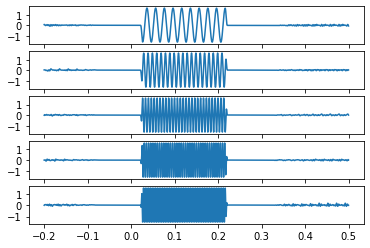

In [18]:
# Plot the stim signals
n_samples = np.shape(stim_epochs_array)[2]
t = np.linspace(RAW_TMIN, RAW_TMAX, n_samples, endpoint = False)

fig, axs = plt.subplots(5)
axs[0].plot(t, stim_epochs_array[0, 0, :])
axs[1].plot(t, stim_epochs_array[0, 1, :])
axs[2].plot(t, stim_epochs_array[0, 2, :])
axs[3].plot(t, stim_epochs_array[0, 3, :])
axs[4].plot(t, stim_epochs_array[0, 4, :])

### Compute coherence

In [9]:
indices = get_coh_indices(N_CHANS)
fmin, fmax = get_fmin_and_fmax(CONDS)
coh_df = pd.DataFrame()
for cond in CONDS:
    coh = get_coh(cond, combined_epochs, indices, fmin, fmax, CONDS, FS)
    coh = clean_coh(coh, N_CHANS)
    cond_coh_df = create_coh_df(coh, cond, CONDS, N_CHANS, SUB)
    coh_df = pd.concat([coh_df, cond_coh_df])
coh_df = coh_df.reset_index()

Adding metadata with 3 columns
Connectivity computation...
    computing connectivity for 310 connections
    using t=0.000s..0.250s for estimation (1251 points)
    computing connectivity for the bands:
     band 1: 48.0Hz..52.0Hz (2 points)
     band 2: 95.9Hz..103.9Hz (3 points)
     band 3: 147.9Hz..151.9Hz (2 points)
     band 4: 195.8Hz..203.8Hz (3 points)
     band 5: 247.8Hz..251.8Hz (2 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 1

    computing connectivity for epoch 190
    computing connectivity for epoch 191
    computing connectivity for epoch 192
    computing connectivity for epoch 193
    computing connectivity for epoch 194
    computing connectivity for epoch 195
    computing connectivity for epoch 196
    computing connectivity for epoch 197
    computing connectivity for epoch 198
    computing connectivity for epoch 199
    computing connectivity for epoch 200
    computing connectivity for epoch 201
    computing connectivity for epoch 202
    computing connectivity for epoch 203
    computing connectivity for epoch 204
    computing connectivity for epoch 205
    computing connectivity for epoch 206
    computing connectivity for epoch 207
    computing connectivity for epoch 208
    computing connectivity for epoch 209
    computing connectivity for epoch 210
    computing connectivity for epoch 211
    computing connectivity for epoch 212
    computing connectivity for epoch 213
    computing co

    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    compu

    computing connectivity for epoch 204
    computing connectivity for epoch 205
    computing connectivity for epoch 206
    computing connectivity for epoch 207
    computing connectivity for epoch 208
    computing connectivity for epoch 209
    computing connectivity for epoch 210
    computing connectivity for epoch 211
    computing connectivity for epoch 212
    computing connectivity for epoch 213
    computing connectivity for epoch 214
    computing connectivity for epoch 215
    computing connectivity for epoch 216
    computing connectivity for epoch 217
    computing connectivity for epoch 218
    computing connectivity for epoch 219
    computing connectivity for epoch 220
    computing connectivity for epoch 221
    computing connectivity for epoch 222
    computing connectivity for epoch 223
    computing connectivity for epoch 224
    computing connectivity for epoch 225
    computing connectivity for epoch 226
    computing connectivity for epoch 227
    computing co

    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    

    computing connectivity for epoch 200
    computing connectivity for epoch 201
    computing connectivity for epoch 202
    computing connectivity for epoch 203
    computing connectivity for epoch 204
    computing connectivity for epoch 205
    computing connectivity for epoch 206
    computing connectivity for epoch 207
    computing connectivity for epoch 208
    computing connectivity for epoch 209
    computing connectivity for epoch 210
    computing connectivity for epoch 211
    computing connectivity for epoch 212
    computing connectivity for epoch 213
    computing connectivity for epoch 214
    computing connectivity for epoch 215
    computing connectivity for epoch 216
    computing connectivity for epoch 217
    computing connectivity for epoch 218
    computing connectivity for epoch 219
    computing connectivity for epoch 220
    computing connectivity for epoch 221
    computing connectivity for epoch 222
    computing connectivity for epoch 223
    computing co

    computing connectivity for the bands:
     band 1: 48.0Hz..52.0Hz (2 points)
     band 2: 95.9Hz..103.9Hz (3 points)
     band 3: 147.9Hz..151.9Hz (2 points)
     band 4: 195.8Hz..203.8Hz (3 points)
     band 5: 247.8Hz..251.8Hz (2 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15


    computing connectivity for epoch 194
    computing connectivity for epoch 195
    computing connectivity for epoch 196
    computing connectivity for epoch 197
    computing connectivity for epoch 198
    computing connectivity for epoch 199
    computing connectivity for epoch 200
    computing connectivity for epoch 201
    computing connectivity for epoch 202
    computing connectivity for epoch 203
    computing connectivity for epoch 204
    computing connectivity for epoch 205
    computing connectivity for epoch 206
    computing connectivity for epoch 207
    computing connectivity for epoch 208
    computing connectivity for epoch 209
    computing connectivity for epoch 210
    computing connectivity for epoch 211
    computing connectivity for epoch 212
    computing connectivity for epoch 213
    computing connectivity for epoch 214
    computing connectivity for epoch 215
    computing connectivity for epoch 216
    computing connectivity for epoch 217
    computing co

Connectivity computation...
    computing connectivity for 310 connections
    using t=0.000s..0.250s for estimation (1251 points)
    computing connectivity for the bands:
     band 1: 48.0Hz..52.0Hz (2 points)
     band 2: 95.9Hz..103.9Hz (3 points)
     band 3: 147.9Hz..151.9Hz (2 points)
     band 4: 195.8Hz..203.8Hz (3 points)
     band 5: 247.8Hz..251.8Hz (2 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity fo

    computing connectivity for epoch 191
    computing connectivity for epoch 192
    computing connectivity for epoch 193
    computing connectivity for epoch 194
    computing connectivity for epoch 195
    computing connectivity for epoch 196
    computing connectivity for epoch 197
    computing connectivity for epoch 198
    computing connectivity for epoch 199
    computing connectivity for epoch 200
    computing connectivity for epoch 201
    computing connectivity for epoch 202
    computing connectivity for epoch 203
    computing connectivity for epoch 204
    computing connectivity for epoch 205
    computing connectivity for epoch 206
    computing connectivity for epoch 207
    computing connectivity for epoch 208
    computing connectivity for epoch 209
    computing connectivity for epoch 210
    computing connectivity for epoch 211
    computing connectivity for epoch 212
    computing connectivity for epoch 213
    computing connectivity for epoch 214
    computing co

In [12]:
coh_df = coh_df.reset_index()
coh_df

,index,sub,cond,chan,50,100,150,200,250
0,0,9,50,1,0.103250,0.061759,0.030829,0.061679,0.055187
1,1,9,50,2,0.150494,0.034989,0.054653,0.065363,0.031277
2,2,9,50,3,0.044568,0.046067,0.060875,0.059236,0.029454
3,3,9,50,4,0.097713,0.049817,0.036001,0.053279,0.031313
4,4,9,50,5,0.012519,0.026121,0.049547,0.048568,0.031164
...,...,...,...,...,...,...,...,...,...
305,57,9,250,58,0.091086,0.023705,0.029659,0.027425,0.024792
306,58,9,250,59,0.073659,0.028758,0.037821,0.029000,0.224433
307,59,9,250,60,0.081519,0.034063,0.051116,0.027132,0.266214
308,60,9,250,61,0.027993,0.047640,0.060025,0.046211,0.405855


('/project2/hcn1/pitch_tracking/scripts/../data/bids/sub-2/eeg/sub-2_task-pitch_run-1_eeg.eeg', '2', 'pitch', '1')
('/project2/hcn1/pitch_tracking/scripts/../data/bids/sub-3/eeg/sub-3_task-pitch_run-1_eeg.eeg', '3', 'pitch', '1')
Used Annotations descriptions: ['100', '150', '200', '250', '50']
Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2400 events and 3501 original time points ...


/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


0 bad epochs dropped
Using matplotlib as 2D backend.
Opening epochs-browser...


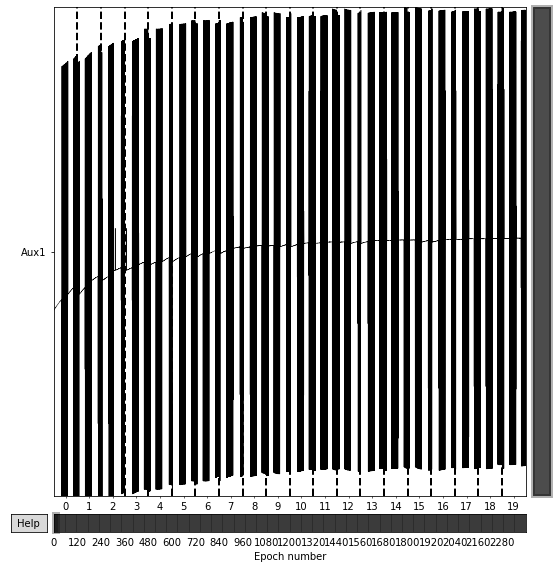

('/project2/hcn1/pitch_tracking/scripts/../data/bids/sub-3/eeg/sub-3_task-pitch_run-2_eeg.eeg', '3', 'pitch', '2')
Used Annotations descriptions: ['100', '150', '200', '250', '50']
Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2400 events and 3501 original time points ...


/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


0 bad epochs dropped
Opening epochs-browser...


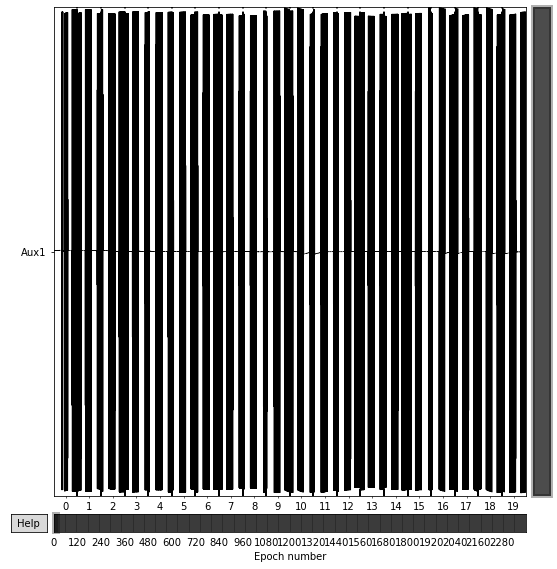

('/project2/hcn1/pitch_tracking/scripts/../data/bids/sub-4/eeg/sub-4_task-pitch_run-1_eeg.eeg', '4', 'pitch', '1')
Used Annotations descriptions: ['100', '150', '200', '250', '50']
Not setting metadata
2461 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2461 events and 3501 original time points ...


/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Ch64', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


0 bad epochs dropped
Opening epochs-browser...


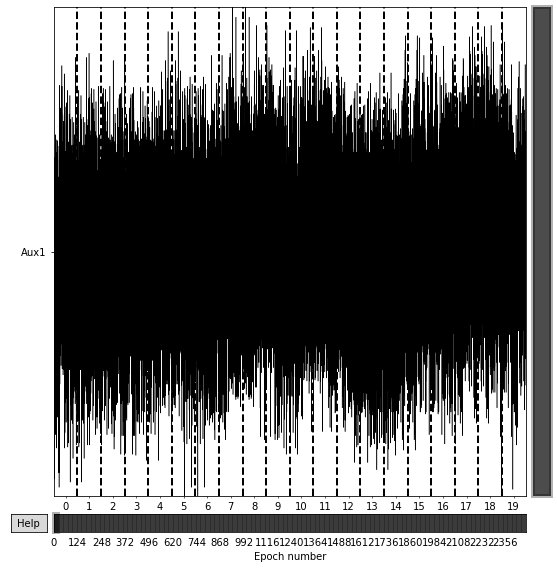

('/project2/hcn1/pitch_tracking/scripts/../data/bids/sub-4/eeg/sub-4_task-pitch_run-2_eeg.eeg', '4', 'pitch', '2')
Used Annotations descriptions: ['100', '150', '200', '250', '50']
Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2400 events and 3501 original time points ...


/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Ch64', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_53153/891457072.py", line 28, in <cell line: 24>
    raw_epochs.load_data()
  File "/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/mne/epochs.py", line 644, in load_data
    self._data = self._get_data()
  File "<decorator-gen-249>", line 12, in _get_data
  File "/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/mne/epochs.py", line -1, in _get_data
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/letitiayhho/

In [48]:
# def get_raw_epochs(BIDS_ROOT, sub, task, run):
#     sub = str(sub)
#     run = str(run)
#     bids_path = BIDSPath(root = BIDS_ROOT,
#                      subject = sub,
#                      task = task,
#                      run = run,
#                      datatype = 'eeg')
#     raw = read_raw_bids(bids_path, verbose = False)
#     raw_events, raw_event_id = mne.events_from_annotations(raw)
#     raw_epochs = mne.Epochs(raw, 
#                     events = raw_events, 
#                     baseline = None,
#                     event_id = raw_event_id)
#     return(raw_epochs)

# # LOOK AT SIMULATED STIM CHANS FOR ALL SUBS
# BIDS_ROOT = '../data/bids'
# DERIV_ROOT = '../data/bids/derivatives'
# layout = BIDSLayout(BIDS_ROOT, derivatives = False)
# fpaths = layout.get(extension = 'eeg',
#                     return_type = 'filename')

# for (FPATH, SUB, TASK, RUN) in iter_BIDSPaths(fpaths):
#     if SUB == '2':
#         continue
#     raw_epochs = get_raw_epochs(BIDS_ROOT, SUB, TASK, RUN)
#     raw_epochs.load_data()
#     raw_epochs.plot(picks = 'stim')

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


('/project2/hcn1/pitch_tracking/scripts/../data/bids/sub-2/eeg/sub-2_task-pitch_run-1_eeg.eeg', '2', 'pitch', '1')
('/project2/hcn1/pitch_tracking/scripts/../data/bids/sub-3/eeg/sub-3_task-pitch_run-1_eeg.eeg', '3', 'pitch', '1')
Used Annotations descriptions: ['100', '150', '200', '250', '50']
Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated
Loading data for 478 events and 3501 original time points ...


/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


0 bad epochs dropped
Loading data for 447 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 500 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 483 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 492 events and 3501 original time points ...
0 bad epochs dropped


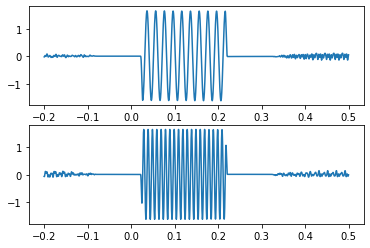

Loading data for 2400 events and 3501 original time points ...
0 bad epochs dropped
Opening epochs-browser...


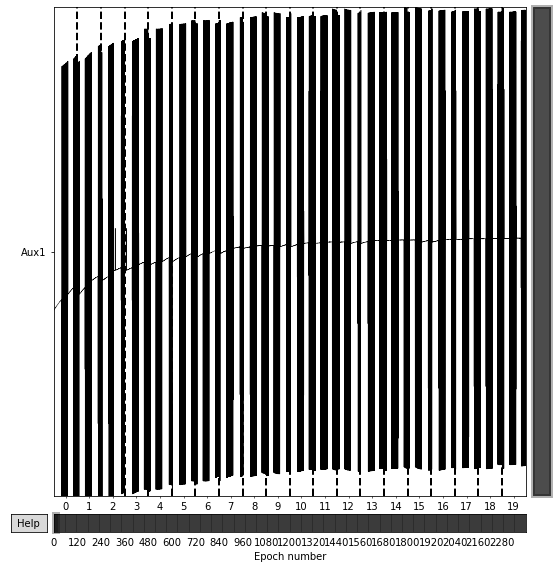

('/project2/hcn1/pitch_tracking/scripts/../data/bids/sub-3/eeg/sub-3_task-pitch_run-2_eeg.eeg', '3', 'pitch', '2')
Used Annotations descriptions: ['100', '150', '200', '250', '50']
Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated
Loading data for 503 events and 3501 original time points ...


/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


0 bad epochs dropped
Loading data for 480 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 504 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 442 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 471 events and 3501 original time points ...
0 bad epochs dropped


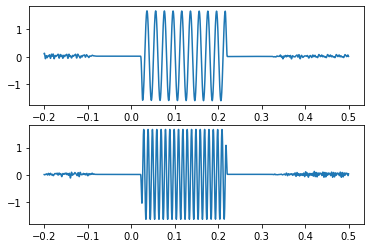

Loading data for 2400 events and 3501 original time points ...
0 bad epochs dropped
Opening epochs-browser...


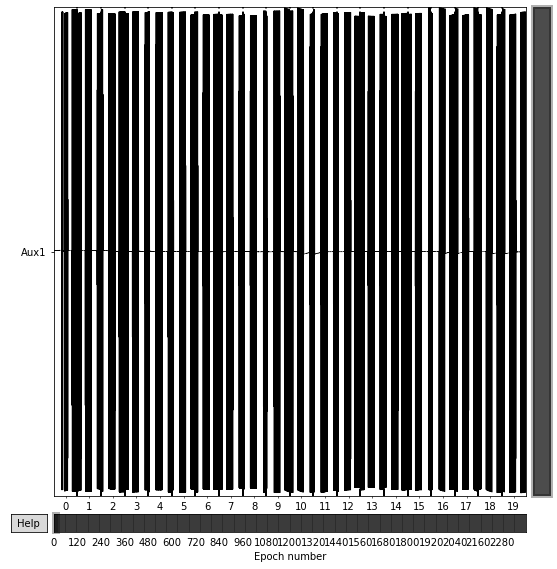

('/project2/hcn1/pitch_tracking/scripts/../data/bids/sub-4/eeg/sub-4_task-pitch_run-1_eeg.eeg', '4', 'pitch', '1')
Used Annotations descriptions: ['100', '150', '200', '250', '50']
Not setting metadata
2461 matching events found
No baseline correction applied
0 projection items activated
Loading data for 512 events and 3501 original time points ...


/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Ch64', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


0 bad epochs dropped
Loading data for 479 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 505 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 498 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 467 events and 3501 original time points ...
0 bad epochs dropped


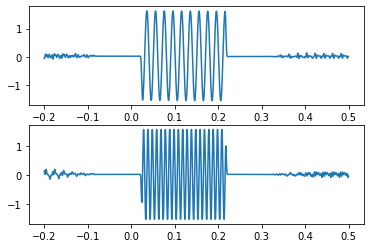

Loading data for 2461 events and 3501 original time points ...
0 bad epochs dropped
Opening epochs-browser...


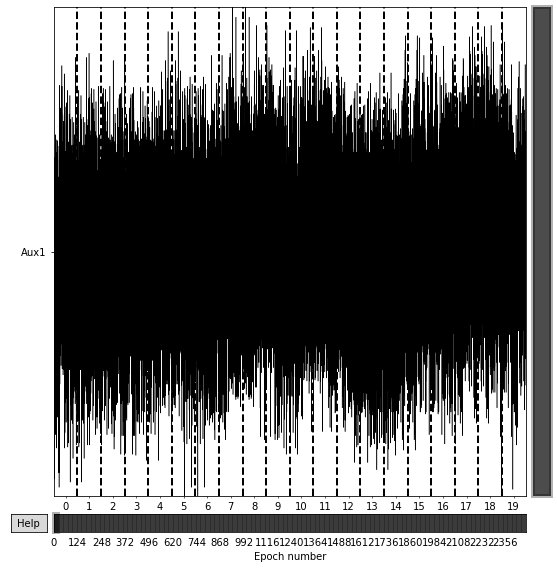

('/project2/hcn1/pitch_tracking/scripts/../data/bids/sub-4/eeg/sub-4_task-pitch_run-2_eeg.eeg', '4', 'pitch', '2')
Used Annotations descriptions: ['100', '150', '200', '250', '50']
Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated
Loading data for 493 events and 3501 original time points ...


/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Ch64', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


0 bad epochs dropped
Loading data for 489 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 469 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 485 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 464 events and 3501 original time points ...
0 bad epochs dropped


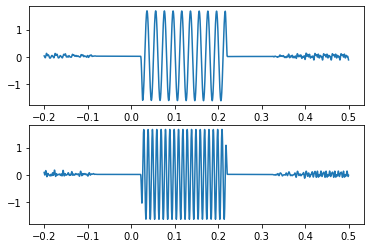

Loading data for 2400 events and 3501 original time points ...
0 bad epochs dropped
Opening epochs-browser...


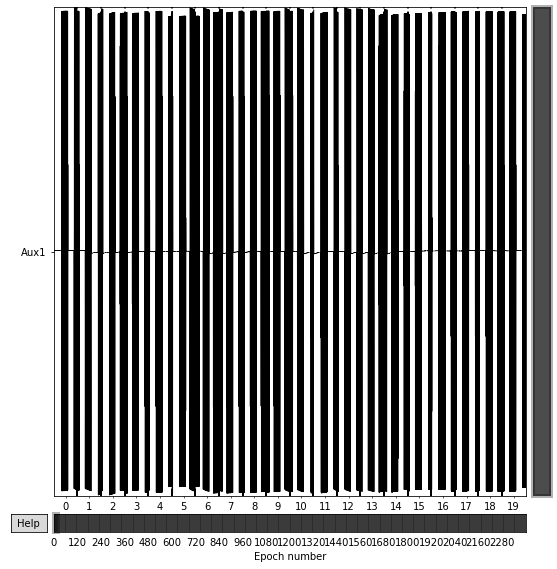

('/project2/hcn1/pitch_tracking/scripts/../data/bids/sub-5/eeg/sub-5_task-pitch_run-1_eeg.eeg', '5', 'pitch', '1')
Used Annotations descriptions: ['100', '150', '200', '250', '50']
Not setting metadata
4800 matching events found
No baseline correction applied
0 projection items activated
Loading data for 973 events and 3501 original time points ...


/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


0 bad epochs dropped
Loading data for 923 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 1009 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 957 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 938 events and 3501 original time points ...
0 bad epochs dropped


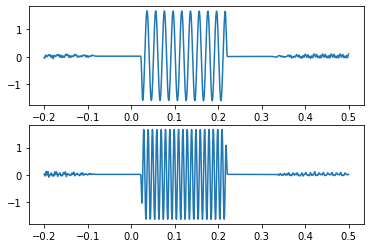

Loading data for 4800 events and 3501 original time points ...
0 bad epochs dropped
Opening epochs-browser...


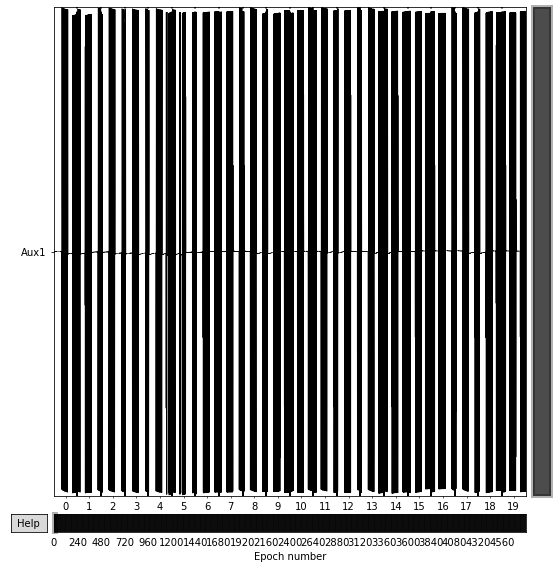

('/project2/hcn1/pitch_tracking/scripts/../data/bids/sub-6/eeg/sub-6_task-pitch_run-1_eeg.eeg', '6', 'pitch', '1')
Used Annotations descriptions: ['100', '150', '200', '250', '50']
Not setting metadata
4800 matching events found
No baseline correction applied
0 projection items activated
Loading data for 975 events and 3501 original time points ...


/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/tmp/ipykernel_53153/891457072.py:9: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


0 bad epochs dropped
Loading data for 897 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 965 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 957 events and 3501 original time points ...


In [ ]:
# LOOK AT SIMULATED STIM CHANS FOR ALL SUBS
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
# fpaths = layout.get(scope = 'preprocessing',
#                 res = 'hi',
#                 suffix='epo',
#                 extension = 'fif.gz',
#                 return_type = 'filename')
fpaths = layout.get(extension = 'eeg',
                    return_type = 'filename')

for (FPATH, SUB, TASK, RUN) in iter_BIDSPaths(fpaths):
    if SUB == '2':
        continue
    n_epochs = 1
    
    # Create epochs from raw data to create simulated stim channels
    raw_epochs = get_raw_epochs(BIDS_ROOT, SUB, TASK, RUN)
    stim_epochs_array = create_stim_epochs_array(raw_epochs, n_epochs, CONDS)

    # Plot the stim signals
    n_samples = np.shape(stim_epochs_array)[2]
    t = np.linspace(RAW_TMIN, RAW_TMAX, n_samples, endpoint = False)

    fig, axs = plt.subplots(2)
    axs[0].plot(t, stim_epochs_array[0, 0, :])
    axs[1].plot(t, stim_epochs_array[0, 1, :])
    plt.show()
    
    raw_epochs.load_data()
    raw_epochs.plot(picks = 'stim')

In [27]:
raw_epochs.info

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG, 1 Stimulus
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 64 items (64 EEG)
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 5000.0 Hz
 meas_date: 1924-12-31 16:03:30 UTC
 nchan: 65
 projs: []
 sfreq: 10000.0 Hz
 subject_info: 4 items (dict)
>

In [11]:
# # Set indices of channel pairs to compute coherence across
# stim_indices = np.array([63, 64, 65, 66, 67]*N_CHANS)
# chan_indices = np.repeat(np.arange(1, 63, 1), 5)
# indices = (stim_indices, chan_indices)

In [12]:
# # Set freqs to compute coherence at
# freqs = np.array([50, 100, 150, 200, 250])
# fmin = freqs - 5
# fmax = freqs + 5

In [75]:
# def get_coh(cond, epochs, indices, CONDS, FS):
#     coh = spectral_connectivity_epochs(
#         combined_epochs[cond], method='coh', mode='fourier', indices=indices,
#         sfreq=FS, fmin=fmin, fmax=fmax, faverage=True, n_jobs=1, verbose = 'WARNING')
#     return(coh)

# def clean_coh(coh, N_CHANS):
#     df = np.zeros((N_CHANS, 5))
#     coh_vals = coh.get_data()
#     for i in range(310):
#         a = i
#         b = a%5
#         chan = int(i/5)
#         val = coh_vals[a, b]
#         df[chan, b] = val
#     return(df)

# def create_coh_df(coh, cond, CONDS, N_CHANS, SUB):
#     coh_df = pd.DataFrame(data = coh, 
#                           columns = CONDS)
#     coh_df.insert(0, 'chan', list(range(1, N_CHANS+1)))
#     coh_df.insert(0, 'cond', np.array([cond]*N_CHANS))
#     coh_df.insert(0, 'sub', np.array([SUB]*N_CHANS))
#     return(coh_df)

# Run coherence for each condition
coh_df = pd.DataFrame()
for cond in CONDS:
    coh = get_coh(cond, combined_epochs, indices, fmin, fmax, FS)
    coh = clean_coh(coh, N_CHANS)
    cond_coh_df = create_coh_df(coh, cond, CONDS, N_CHANS, SUB)
    coh_df = pd.concat([coh_df, cond_coh_df])

Adding metadata with 3 columns
Connectivity computation...
    computing connectivity for 310 connections
    using t=0.000s..0.250s for estimation (1251 points)
    computing connectivity for the bands:
     band 1: 48.0Hz..52.0Hz (2 points)
     band 2: 95.9Hz..103.9Hz (3 points)
     band 3: 147.9Hz..151.9Hz (2 points)
     band 4: 195.8Hz..203.8Hz (3 points)
     band 5: 247.8Hz..251.8Hz (2 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 1

    computing connectivity for epoch 190
    computing connectivity for epoch 191
    computing connectivity for epoch 192
    computing connectivity for epoch 193
    computing connectivity for epoch 194
    computing connectivity for epoch 195
    computing connectivity for epoch 196
    computing connectivity for epoch 197
    computing connectivity for epoch 198
    computing connectivity for epoch 199
    computing connectivity for epoch 200
    computing connectivity for epoch 201
    computing connectivity for epoch 202
    computing connectivity for epoch 203
    computing connectivity for epoch 204
    computing connectivity for epoch 205
    computing connectivity for epoch 206
    computing connectivity for epoch 207
    computing connectivity for epoch 208
    computing connectivity for epoch 209
    computing connectivity for epoch 210
    computing connectivity for epoch 211
    computing connectivity for epoch 212
    computing connectivity for epoch 213
    computing co

    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    compu

    computing connectivity for epoch 204
    computing connectivity for epoch 205
    computing connectivity for epoch 206
    computing connectivity for epoch 207
    computing connectivity for epoch 208
    computing connectivity for epoch 209
    computing connectivity for epoch 210
    computing connectivity for epoch 211
    computing connectivity for epoch 212
    computing connectivity for epoch 213
    computing connectivity for epoch 214
    computing connectivity for epoch 215
    computing connectivity for epoch 216
    computing connectivity for epoch 217
    computing connectivity for epoch 218
    computing connectivity for epoch 219
    computing connectivity for epoch 220
    computing connectivity for epoch 221
    computing connectivity for epoch 222
    computing connectivity for epoch 223
    computing connectivity for epoch 224
    computing connectivity for epoch 225
    computing connectivity for epoch 226
    computing connectivity for epoch 227
    computing co

    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    

    computing connectivity for epoch 200
    computing connectivity for epoch 201
    computing connectivity for epoch 202
    computing connectivity for epoch 203
    computing connectivity for epoch 204
    computing connectivity for epoch 205
    computing connectivity for epoch 206
    computing connectivity for epoch 207
    computing connectivity for epoch 208
    computing connectivity for epoch 209
    computing connectivity for epoch 210
    computing connectivity for epoch 211
    computing connectivity for epoch 212
    computing connectivity for epoch 213
    computing connectivity for epoch 214
    computing connectivity for epoch 215
    computing connectivity for epoch 216
    computing connectivity for epoch 217
    computing connectivity for epoch 218
    computing connectivity for epoch 219
    computing connectivity for epoch 220
    computing connectivity for epoch 221
    computing connectivity for epoch 222
    computing connectivity for epoch 223
    computing co

    computing connectivity for the bands:
     band 1: 48.0Hz..52.0Hz (2 points)
     band 2: 95.9Hz..103.9Hz (3 points)
     band 3: 147.9Hz..151.9Hz (2 points)
     band 4: 195.8Hz..203.8Hz (3 points)
     band 5: 247.8Hz..251.8Hz (2 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15


    computing connectivity for epoch 194
    computing connectivity for epoch 195
    computing connectivity for epoch 196
    computing connectivity for epoch 197
    computing connectivity for epoch 198
    computing connectivity for epoch 199
    computing connectivity for epoch 200
    computing connectivity for epoch 201
    computing connectivity for epoch 202
    computing connectivity for epoch 203
    computing connectivity for epoch 204
    computing connectivity for epoch 205
    computing connectivity for epoch 206
    computing connectivity for epoch 207
    computing connectivity for epoch 208
    computing connectivity for epoch 209
    computing connectivity for epoch 210
    computing connectivity for epoch 211
    computing connectivity for epoch 212
    computing connectivity for epoch 213
    computing connectivity for epoch 214
    computing connectivity for epoch 215
    computing connectivity for epoch 216
    computing connectivity for epoch 217
    computing co

Connectivity computation...
    computing connectivity for 310 connections
    using t=0.000s..0.250s for estimation (1251 points)
    computing connectivity for the bands:
     band 1: 48.0Hz..52.0Hz (2 points)
     band 2: 95.9Hz..103.9Hz (3 points)
     band 3: 147.9Hz..151.9Hz (2 points)
     band 4: 195.8Hz..203.8Hz (3 points)
     band 5: 247.8Hz..251.8Hz (2 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity fo

    computing connectivity for epoch 191
    computing connectivity for epoch 192
    computing connectivity for epoch 193
    computing connectivity for epoch 194
    computing connectivity for epoch 195
    computing connectivity for epoch 196
    computing connectivity for epoch 197
    computing connectivity for epoch 198
    computing connectivity for epoch 199
    computing connectivity for epoch 200
    computing connectivity for epoch 201
    computing connectivity for epoch 202
    computing connectivity for epoch 203
    computing connectivity for epoch 204
    computing connectivity for epoch 205
    computing connectivity for epoch 206
    computing connectivity for epoch 207
    computing connectivity for epoch 208
    computing connectivity for epoch 209
    computing connectivity for epoch 210
    computing connectivity for epoch 211
    computing connectivity for epoch 212
    computing connectivity for epoch 213
    computing connectivity for epoch 214
    computing co

In [76]:
# coh_df.insert(0, 'chan', list(range(1, N_CHANS+1)))
# coh_df
# coh_df

,sub,cond,chan,50,100,150,200,250
0,9,50,1,0.103250,0.061759,0.030829,0.061679,0.055187
1,9,50,2,0.150494,0.034989,0.054653,0.065363,0.031277
2,9,50,3,0.044568,0.046067,0.060875,0.059236,0.029454
3,9,50,4,0.097713,0.049817,0.036001,0.053279,0.031313
4,9,50,5,0.012519,0.026121,0.049547,0.048568,0.031164
...,...,...,...,...,...,...,...,...
57,9,250,58,0.091086,0.023705,0.029659,0.027425,0.024792
58,9,250,59,0.073659,0.028758,0.037821,0.029000,0.224433
59,9,250,60,0.081519,0.034063,0.051116,0.027132,0.266214
60,9,250,61,0.027993,0.047640,0.060025,0.046211,0.405855


In [25]:
# coh = spectral_connectivity_epochs(
#     combined_epochs, method='coh', mode='fourier', indices=indices,
#     sfreq=FS, fmin=fmin, fmax=fmax, faverage=True, n_jobs=1)
# freqs = coh.freqs

# print('Frequencies in Hz over which coherence was averaged for 50 Hz: ')
# print(freqs[0])
# print('Frequencies in Hz over which coherence was averaged for 100 Hz: ')
# print(freqs[1])
# print('Frequencies in Hz over which coherence was averaged for 150 Hz: ')
# print(freqs[2])
# print('Frequencies in Hz over which coherence was averaged for 200 Hz: ')
# print(freqs[3])
# print('Frequencies in Hz over which coherence was averaged for 250 Hz: ')
# print(freqs[4])

Replacing existing metadata with 3 columns
Connectivity computation...
    computing connectivity for 310 connections
    using t=0.000s..0.250s for estimation (1251 points)
    computing connectivity for the bands:
     band 1: 48.0Hz..52.0Hz (2 points)
     band 2: 95.9Hz..103.9Hz (3 points)
     band 3: 147.9Hz..151.9Hz (2 points)
     band 4: 195.8Hz..203.8Hz (3 points)
     band 5: 247.8Hz..251.8Hz (2 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity

    computing connectivity for epoch 190
    computing connectivity for epoch 191
    computing connectivity for epoch 192
    computing connectivity for epoch 193
    computing connectivity for epoch 194
    computing connectivity for epoch 195
    computing connectivity for epoch 196
    computing connectivity for epoch 197
    computing connectivity for epoch 198
    computing connectivity for epoch 199
    computing connectivity for epoch 200
    computing connectivity for epoch 201
    computing connectivity for epoch 202
    computing connectivity for epoch 203
    computing connectivity for epoch 204
    computing connectivity for epoch 205
    computing connectivity for epoch 206
    computing connectivity for epoch 207
    computing connectivity for epoch 208
    computing connectivity for epoch 209
    computing connectivity for epoch 210
    computing connectivity for epoch 211
    computing connectivity for epoch 212
    computing connectivity for epoch 213
    computing co

    computing connectivity for epoch 390
    computing connectivity for epoch 391
    computing connectivity for epoch 392
    computing connectivity for epoch 393
    computing connectivity for epoch 394
    computing connectivity for epoch 395
    computing connectivity for epoch 396
    computing connectivity for epoch 397
    computing connectivity for epoch 398
    computing connectivity for epoch 399
    computing connectivity for epoch 400
    computing connectivity for epoch 401
    computing connectivity for epoch 402
    computing connectivity for epoch 403
    computing connectivity for epoch 404
    computing connectivity for epoch 405
    computing connectivity for epoch 406
    computing connectivity for epoch 407
    computing connectivity for epoch 408
    computing connectivity for epoch 409
    computing connectivity for epoch 410
    computing connectivity for epoch 411
    computing connectivity for epoch 412
    computing connectivity for epoch 413
    computing co

    computing connectivity for epoch 590
    computing connectivity for epoch 591
    computing connectivity for epoch 592
    computing connectivity for epoch 593
    computing connectivity for epoch 594
    computing connectivity for epoch 595
    computing connectivity for epoch 596
    computing connectivity for epoch 597
    computing connectivity for epoch 598
    computing connectivity for epoch 599
    computing connectivity for epoch 600
    computing connectivity for epoch 601
    computing connectivity for epoch 602
    computing connectivity for epoch 603
    computing connectivity for epoch 604
    computing connectivity for epoch 605
    computing connectivity for epoch 606
    computing connectivity for epoch 607
    computing connectivity for epoch 608
    computing connectivity for epoch 609
    computing connectivity for epoch 610
    computing connectivity for epoch 611
    computing connectivity for epoch 612
    computing connectivity for epoch 613
    computing co

    computing connectivity for epoch 790
    computing connectivity for epoch 791
    computing connectivity for epoch 792
    computing connectivity for epoch 793
    computing connectivity for epoch 794
    computing connectivity for epoch 795
    computing connectivity for epoch 796
    computing connectivity for epoch 797
    computing connectivity for epoch 798
    computing connectivity for epoch 799
    computing connectivity for epoch 800
    computing connectivity for epoch 801
    computing connectivity for epoch 802
    computing connectivity for epoch 803
    computing connectivity for epoch 804
    computing connectivity for epoch 805
    computing connectivity for epoch 806
    computing connectivity for epoch 807
    computing connectivity for epoch 808
    computing connectivity for epoch 809
    computing connectivity for epoch 810
    computing connectivity for epoch 811
    computing connectivity for epoch 812
    computing connectivity for epoch 813
    computing co

    computing connectivity for epoch 990
    computing connectivity for epoch 991
    computing connectivity for epoch 992
    computing connectivity for epoch 993
    computing connectivity for epoch 994
    computing connectivity for epoch 995
    computing connectivity for epoch 996
    computing connectivity for epoch 997
    computing connectivity for epoch 998
    computing connectivity for epoch 999
    computing connectivity for epoch 1000
    computing connectivity for epoch 1001
    computing connectivity for epoch 1002
    computing connectivity for epoch 1003
    computing connectivity for epoch 1004
    computing connectivity for epoch 1005
    computing connectivity for epoch 1006
    computing connectivity for epoch 1007
    computing connectivity for epoch 1008
    computing connectivity for epoch 1009
    computing connectivity for epoch 1010
    computing connectivity for epoch 1011
    computing connectivity for epoch 1012
    computing connectivity for epoch 1013
  

    computing connectivity for epoch 1186
    computing connectivity for epoch 1187
    computing connectivity for epoch 1188
    computing connectivity for epoch 1189
    computing connectivity for epoch 1190
    computing connectivity for epoch 1191
    computing connectivity for epoch 1192
    computing connectivity for epoch 1193
    computing connectivity for epoch 1194
    computing connectivity for epoch 1195
    computing connectivity for epoch 1196
    computing connectivity for epoch 1197
    computing connectivity for epoch 1198
    computing connectivity for epoch 1199
    computing connectivity for epoch 1200
    computing connectivity for epoch 1201
    computing connectivity for epoch 1202
    computing connectivity for epoch 1203
    computing connectivity for epoch 1204
    computing connectivity for epoch 1205
    computing connectivity for epoch 1206
    computing connectivity for epoch 1207
    computing connectivity for epoch 1208
    computing connectivity for epo

    computing connectivity for epoch 1382
    computing connectivity for epoch 1383
    computing connectivity for epoch 1384
    computing connectivity for epoch 1385
    computing connectivity for epoch 1386
    computing connectivity for epoch 1387
    computing connectivity for epoch 1388
    computing connectivity for epoch 1389
    computing connectivity for epoch 1390
    computing connectivity for epoch 1391
    computing connectivity for epoch 1392
    computing connectivity for epoch 1393
    computing connectivity for epoch 1394
    computing connectivity for epoch 1395
    computing connectivity for epoch 1396
    computing connectivity for epoch 1397
    computing connectivity for epoch 1398
    computing connectivity for epoch 1399
    computing connectivity for epoch 1400
    computing connectivity for epoch 1401
    computing connectivity for epoch 1402
    computing connectivity for epoch 1403
    computing connectivity for epoch 1404
    computing connectivity for epo

    computing connectivity for epoch 1578
    computing connectivity for epoch 1579
    computing connectivity for epoch 1580
    computing connectivity for epoch 1581
    computing connectivity for epoch 1582
    computing connectivity for epoch 1583
    computing connectivity for epoch 1584
    computing connectivity for epoch 1585
    computing connectivity for epoch 1586
    computing connectivity for epoch 1587
    computing connectivity for epoch 1588
    computing connectivity for epoch 1589
    computing connectivity for epoch 1590
    computing connectivity for epoch 1591
    computing connectivity for epoch 1592
    computing connectivity for epoch 1593
    computing connectivity for epoch 1594
    computing connectivity for epoch 1595
    computing connectivity for epoch 1596
    computing connectivity for epoch 1597
    computing connectivity for epoch 1598
    computing connectivity for epoch 1599
    computing connectivity for epoch 1600
    computing connectivity for epo

    computing connectivity for epoch 1774
    computing connectivity for epoch 1775
    computing connectivity for epoch 1776
    computing connectivity for epoch 1777
    computing connectivity for epoch 1778
    computing connectivity for epoch 1779
    computing connectivity for epoch 1780
    computing connectivity for epoch 1781
    computing connectivity for epoch 1782
    computing connectivity for epoch 1783
    computing connectivity for epoch 1784
    computing connectivity for epoch 1785
    computing connectivity for epoch 1786
    computing connectivity for epoch 1787
    computing connectivity for epoch 1788
    computing connectivity for epoch 1789
    computing connectivity for epoch 1790
    computing connectivity for epoch 1791
    computing connectivity for epoch 1792
    computing connectivity for epoch 1793
    computing connectivity for epoch 1794
    computing connectivity for epoch 1795
    computing connectivity for epoch 1796
    computing connectivity for epo

In [11]:
# data = combined_epochs.get_data()
# freqs = np.array([50, 100, 150, 200, 250])
# foi = np.stack((freqs - 5, freqs + 5)).T
# # fmin = freq - 5
# # fmax = freqs + 5
# # foi = np.concatenate(fmin, fmax)
# foi
# coh = EpochSpectralConnectivity(
#     data, freqs, n_nodes = 310, indices = 'all',method = 'imcoh', mode='fourier')

array([[ 45,  55],
       [ 95, 105],
       [145, 155],
       [195, 205],
       [245, 255]])

In [65]:
# coh_df

array([[1.        , 0.03553919, 0.02375357, 0.01650441, 0.02783876,
        0.02884122],
       [1.        , 0.01756459, 0.00951065, 0.00633026, 0.01997641,
        0.03273319],
       [1.        , 0.03665346, 0.0345557 , 0.01859995, 0.0225321 ,
        0.02535346],
       [1.        , 0.0451385 , 0.02551724, 0.00623338, 0.03882852,
        0.0268653 ],
       [1.        , 0.01543893, 0.04209757, 0.03387247, 0.02253581,
        0.00683295],
       [1.        , 0.01974437, 0.00865967, 0.0217572 , 0.01489937,
        0.03502125],
       [1.        , 0.00477624, 0.006171  , 0.01789229, 0.03332508,
        0.06969275],
       [1.        , 0.00310636, 0.02242035, 0.02901781, 0.04138027,
        0.03323897],
       [1.        , 0.02747122, 0.04028795, 0.02742887, 0.02836565,
        0.01463101],
       [1.        , 0.01939304, 0.0252302 , 0.0211385 , 0.02685142,
        0.07107452],
       [1.        , 0.02859745, 0.03447119, 0.02963662, 0.02941357,
        0.02297964],
       [1.        , 0

In [14]:
# spectral_connectivity_time(combined_epochs, indices = indices, sfreq = FS, foi = foi)

Adding metadata with 3 columns


UnboundLocalError: local variable 'f_vec' referenced before assignment

In [ ]:
# TRY SOME ANALYSES WITH THIS 

coh = spectral_connectivity_epochs(
    data, method='coh', mode='fourier', indices=indices,
    sfreq=FS, fmin=fmin, fmax=fmax, faverage=True, n_jobs=1)
freqs = coh.freqs

print('Frequencies in Hz over which coherence was averaged for 50 Hz: ')
print(freqs[0])
print('Frequencies in Hz over which coherence was averaged for 100 Hz: ')
print(freqs[1])
print('Frequencies in Hz over which coherence was averaged for 150 Hz: ')
print(freqs[2])
print('Frequencies in Hz over which coherence was averaged for 200 Hz: ')
print(freqs[3])
print('Frequencies in Hz over which coherence was averaged for 250 Hz: ')
print(freqs[4])



In [34]:
np.shape(coh) # n_chans * n_stim, n_freqs
# want it to be by n_trials also
print(np.shape(coh.get_data()))
coh.get_data()[120:125,:]
type(coh)
# COMPUTE COHERENCE SEPARATELY FOR EACH CONDITIONSNSN!!!

# TRY THE COH THAT ENDS IN TIME

(310, 5)


mne_connectivity.base.SpectralConnectivity

In [ ]:
# Create data frame (chan, stim_chan, coh_at_50hz, coh_at_100hz, coh_at_150, coh_at_200, coh_at_250)

In [1]:
epochs.events

NameError: name 'epochs' is not defined

In [ ]:
mne.pick_types(combined_epochs.info, stim = True, eeg = True)

In [ ]:
mne.pick_types(simulated_epochs.info, stim = True)